# MGSC 404 Final Project
## Bixi Rebalancing Problem

Group 9: Inès Battah, Rafael Dhaene, Teghwin Kohli, Victor Chamoux, Victor Liu

### Introduction
The problem we will solve below is based on the mismatch between the supply and demand of bixis generated by an uneven distribution of bikes among the stations across Chicago. As Bixi users tend to follow specific destination flows when going to work, school, or other daily activities (mainly moving from residential areas to downtown in the morning, and vice-versa in the afternoon), many stations with a high demand for bikes end up being full, which stops other users from being able to dock their bicycles at their destination.

As the problem required our group to adopt a business perspective as being part of the Bixi team, our final objective is to increase the company’s profit margins by optimally relocating bicycles around the city, and consequently allowing more customers to utilize Bixi’s service. 

In order to do so, we will build a linear optimization model that allows Bixi to relocate the optimal number of bikes, between the optimal set of stations around the city, at a specific point in time. By moving the bicycles from the stations with the highest demand for bikes to the stations with the lowest demand, more users will be able to pay for Bixi’s service, thus increasing the company’s profit generation.

Three datasets were provided to our group for the linear optimization problem to be developed:

1. A dataset with all the stations in Chicago, along with the station’s ID, name, longitude, latitude, and total bike capacity

2. A dataset with information of all trips taking place in the 3rd quarter of 2017, along with the trip ID, the initial and final station id, as well as the trip duration, date, and time.

3. A similar dataset with information of all trips taking place in the 4th quarter or 2017, with the same columns as the point above

Because users tend to utilize Bixi’s service more often in the Summer (Q3), compared to the Fall (Q4), our group decided to disregard the dataset with the 4th quarter of 2017, and instead leverage the two other datasets to develop our linear regression model.


## I) Data Pre-Processing

### Importing modules

In [1]:
import numpy as np
from gurobipy import *
from datascience import *
from math import cos, asin, sqrt, pi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

### Importing Raw Data

In [2]:
stations = Table.read_table("C:/Users/teghw/Desktop/Fall 2022/MGSC 404 - Decision Analytics/Final Project/Divvy_Stations_2017_Q3Q4.csv")
tripsQ3 = Table.read_table("C:/Users/teghw/Desktop/Fall 2022/MGSC 404 - Decision Analytics/Final Project/Divvy_Trips_2017_Q3.csv")

### Isolating Date and Time from the Trips Table

We apply the .split() function to split the date and time of the trips. We define two functions that will each return the date, and time of any trip in the dataset

In [3]:
def hour_split(s):
    return int(s.split(' ')[1][0:2])
def date_split(s):
    return s.split(' ')[0]

We then redefine the Trips dataset by creating 4 new columns where we will store the start/end date and time of all the trips. We also remove the columns that will not be utilized in our linear optimization model with the .drop() function.

In [4]:
trips = tripsQ3.with_columns('start date', tripsQ3.apply(date_split, 'start_time'), 'start hour', tripsQ3.apply(hour_split, 'start_time'), 'finish date', tripsQ3.apply(date_split, 'end_time'), 'finish hour', tripsQ3.apply(hour_split, 'end_time'))
trips = trips.drop('bikeid','gender', 'birthyear', 'to_station_name', 'from_station_name', 'start_time', 'end_time') # dropping extra columns 

In [5]:
trips

trip_id,tripduration,from_station_id,to_station_id,usertype,start date,start hour,finish date,finish hour
16734065,349,216,259,Subscriber,9/30/2017,23,10/1/2017,0
16734064,354,216,259,Subscriber,9/30/2017,23,10/1/2017,0
16734063,226,141,144,Subscriber,9/30/2017,23,10/1/2017,0
16734062,521,96,217,Customer,9/30/2017,23,10/1/2017,0
16734061,530,96,217,Subscriber,9/30/2017,23,10/1/2017,0
16734060,1072,478,117,Subscriber,9/30/2017,23,10/1/2017,0
16734059,497,114,296,Subscriber,9/30/2017,23,10/1/2017,0
16734058,214,87,127,Subscriber,9/30/2017,23,10/1/2017,0
16734057,1398,90,86,Customer,9/30/2017,23,10/1/2017,0
16734056,1072,296,268,Subscriber,9/30/2017,23,10/1/2017,0


## II) Data Analysis, Defining Functions, and Calculating Essential Metrics

### 1. Code to calculate pair distance

A very important part of the model is to calculate the distance between stations in Chicago to determine the optimal trajectory of each truck. We thus define a function that applies the Haversine formula, allowing us to calculate, in kilometers, the distance between two stations by taking their latitude and longitude information.

In [6]:
def distance(lat1, lat2, lon1, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    h = 12742*asin(sqrt(a))*1.15 # to convert air distance between two points to street distance
    return h*1000

Once the function is defined, we can create a matrix table that will store the distance between every possible pair of stations in Chicago by using a nested for loop that applies the distance function. 

In [7]:
matrix=Table().with_columns("id",stations.column("id"))
for i in stations.column("id"):
    matrix=matrix.with_columns(str(i),0)
for i in range(585):
    for j in range(585):
        matrix[i+1][j] = distance(stations.column("latitude")[i],stations.column("latitude")[j],stations.column("longitude")[i],stations.column("longitude")[j])

In [8]:
matrix

id,2,3,4,5,6,7,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,66,67,68,69,71,72,73,74,75,76,77,80,81,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,152,153,154,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,188,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,222,223,224,225,226,227,228,229,230,231,232,233,234,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,267,268,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,359,364,365,366,367,368,369,370,373,374,375,376,377,378,381,382,383,384,385,386,388,390,391,392,393,394,395,396,397,398,399,400,401,402,403,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,514,515,517,518,519,520,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,622,623,624,625,626
2,0,1264,2657,764,1318,1300,8367,14644,14997,7798,3748,4158,6423,6141,1833,3973,5364,3285,3462,3774,1978,2736,1805,4854,5362,5083,5401,2986,3501,722,6578,2179,1437,977,1588,644,1172,1036,3096,1043,1278,390,3295,1782,3475,1078,978,1518,1283,2625,4102,2933,2784,2305,6857,1288,5174,6379,3202,2363,7049,1949,6901,3258,2112,2195,3024,1815,676,2111,3389,1338,3302,3158,4637,7257,3613,1229,692,2176,3916,5685,5570,12894,2536,1436,1411,2141,2152,12903,13578,2062,2808,2258,2572,2814,2407,2903,2854,6174,9886,8251,8082,8730,4803,4620,3114,9863,5044,9408,5939,1848,4682,6904,5955,4604,6511,9260,3637,2380,2795,3826,3777,3431,4090,3027,5205,2327,6114,6235,2842,3973,3931,5352,5310,4973,8015,8632,9066,8110,7865,7432,7417,7904,2533,9403,8967,1882,10205,8123,6311,1610,1852,3061,4212,3387,2627,1994,1345,3555,6456,2623,6895,3936,2132,3680,6145,5832,8585,4154,7608,7878,1915,1899,4479,1446,1068,1820,864,2799,2022,8517,6997,3455,6858,10428,5181,4504,4826,5212,3940,5687,2319,2561,7309,5706,5237,8095,3734,2818,7430,7490,8902,6383,5497,6193,8892,10070,9902,9563,9824,11382,9641,3053,11730,4124,4402,12049,13228,10470,2983,12872,12562,11236,11172,11185,11045,10620,11328,8968,12045,8741,12340,10315,1117,10174,10633,9276,9038,10753,4759,6756,5179,1348,6944,8980,4559,15387,7770,4804,2409,3960,4622,8514,4789,6183,6382,5741,7128,2941,1132,402,5196,1409,1500,5778,4769,10092,4116,11130,11914,13566,13007,8490,11918,11613,9023,8162,4178,7411,9183,9676,7217,11003,7018,10259,7936,7822,13288,10783,6569,11590,6263,12441,4917,10792,8396,3957,884,10121,12348,7239,13190,12434,6594,11352,7355,10249,4914,7814,5944,8426,5760,8606,2767,2403,5425,7134,1811,5122,7654,12915,11075,3978,10556,7704,7279,5161,9470,13783,18154,17620,14069,14419,4099,3732,3976,5678,6758,6419,7595,284

Defining pair_distance function, to fetch the distance between two stations ids from the matrix and converting it to kms.

In [9]:
def pair_distance(id1,id2):
    return round(matrix.where("id",id1).column(str(id2))[0]/1000,2)

In [10]:
pair_distance(2,626) #example: distance between station id 2 and 626 is 1.6km

1.6000000000000001

### 2. Calculating the average revenue per trip

In [11]:
percentage_of_usertype = trips.group("usertype")
percentage_of_usertype = percentage_of_usertype.with_column("% of ustertype",percentage_of_usertype.column("count")/sum(percentage_of_usertype.column("count")))
percentage_of_usertype

usertype,count,% of ustertype
Customer,441623,0.274595
Dependent,3,1.86536e-06
Subscriber,1166644,0.725403


73% are members and 27% are customers <p>
average revenue per trip for members = \\$15 monthly subscription/40 trips in a month = \\$0.38 <p>
average revenue per trip for customers = \\$3 (research) <p>

In [12]:
avg_revenue= 0.38*0.73 + 3*0.27
print(avg_revenue)

1.0874000000000001


### 3. Identifying the busiest stations 

In order to confirm our assumption that users mainly pick up and drop off bicycles before and after working hours, we create a histogram displaying the percentage of bikes picked up and dropped off relative to the hour of the day. We note that users mainly utilize the service around 8 am, and around 5 pm, which confirms our assumption.

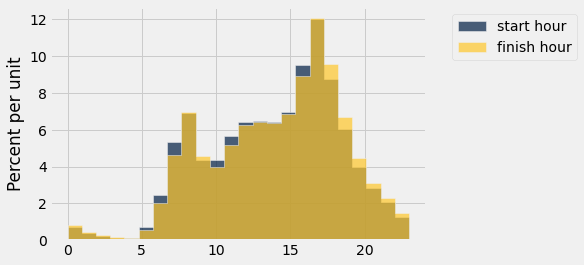

In [13]:
trips.hist(["start hour", "finish hour"], bins=24)

In the following cell, choose a target hour for the model to run. The histogram is there for visual aid for the user to chose a target time.

In [14]:
target_hour=int(input("Please input the target hour (24h format) for the following analysis: "))

Please input the target hour (24h format) for the following analysis: 8


#### For dropoffs

Selecting only trips occurring during target hour, we decided to calculate the average number of bikes dropped off at station i within that hour. Calculating the total number of drop offs for that target hour over one quarter, we divided this count by 92 (as it represents the number of days in this quarter). This computation calculates the average number of drop offs during that hour in the quarter. We created a new column where we apply this computation, titled ‘drops/hr’. 

In [15]:
trips_drops=trips.group(["to_station_id","finish hour"])
trips_drops=trips_drops.with_column("drops/hr",trips_drops.column("count")/92).where("finish hour",target_hour)
trips_drops.sort("drops/hr", descending=True)

to_station_id,finish hour,count,drops/hr
287,8,3359,36.5109
43,8,3318,36.0652
81,8,3229,35.0978
100,8,2895,31.4674
40,8,2115,22.9891
77,8,2042,22.1957
91,8,1865,20.2717
48,8,1806,19.6304
192,8,1697,18.4457
195,8,1576,17.1304


#### For pickups

Similar to drop offs, we calculated the average number of pickups during the target hour over the quarter.

In [16]:
trips_pickups=trips.group(["from_station_id","start hour"])
trips_pickups=trips_pickups.with_column("pickups/hr",trips_pickups.column("count")/92).where("start hour",target_hour)
trips_pickups.sort("pickups/hr", descending=True)

from_station_id,start hour,count,pickups/hr
192,8,2895,31.4674
91,8,2764,30.0435
77,8,2468,26.8261
18,8,1564,17
191,8,1453,15.7935
174,8,1377,14.9674
255,8,1168,12.6957
133,8,1115,12.1196
195,8,1081,11.75
66,8,1078,11.7174


#### Combining the two tables to calculate Average Surplus

We then decided to join these two newly created tables into one table (called ‘final_avg'). In this table, we can clearly visualize the average number of pickups and dropoffs per hour for every station ID. 

Finally, we calculate the Average Bike Surplus (per station). This is calculated by subtracting average number of pickups per station from the average number of drop offs. 

Positive values indicate a surplus, pickups < drop-offs. <p>
Negative values indicate a deficit, where pickups > drop-offs.

In [17]:
merged_table=trips_drops.join('to_station_id',trips_pickups,'from_station_id')
merged_table=merged_table.with_column("avg bike surplus",merged_table.column("drops/hr")-merged_table.column("pickups/hr")) # average surplus

#### Creating a sub-table with only surplus stations (i.e stations with a positive average surplus)

In [18]:
surplus_stations=merged_table.where("avg bike surplus",are.above(0)).drop("finish hour","count","drops/hr","start hour","count_2","pickups/hr")

#### Creating a sub-table with only deficit stations (i.e stations with a negative average surplus)

In [19]:
deficit_stations=merged_table.where("avg bike surplus",are.below(0)).drop("finish hour","count","drops/hr","start hour","count_2","pickups/hr")
deficit_stations=deficit_stations.with_column("avg bike deficit",deficit_stations.column("avg bike surplus")*-1).drop("avg bike surplus") # taking the absoulte value of the deficit

#### Shortlisting the stations using a threshold

Threshold is the minimum deficit needed at a station for it to qualify for the rearrangment exercise. For starting, please input a threshold of 4. <p>
(This is discussed more in detail in the sensitivity analysis)


In [20]:
threshold=int(input("This is the minimum threshold of deficit needed to undergo rearrangment: "))

This is the minimum threshold of deficit needed to undergo rearrangment: 4


Now using this threshold, we identify the stations which have an average deficit higher than the threshold defined:

In [21]:
deficit_stations=deficit_stations.where("avg bike deficit", are.above(threshold))

Once the stations are identified, we need the same number of surplus stations to cover the deficit at these stations:

In [22]:
num_stations=np.shape(deficit_stations)[1][0][0] # counting the number of deficit stations having a shortage above the threshold

In order to be able to supply these deficit stations, we need to transport bikes from the same number of surplus stations. Thus, we decided to select the same number of surplus stations having the highest average bike surplus. 

In [23]:
surplus_stations=surplus_stations.sort("avg bike surplus", descending=True).take(np.arange(0,num_stations))

Therefore, the objective is to transport bikes from the surplus stations to the deficit stations, which will simultaneously free spots in stations containing too many bikes, and meet demand in stations containing not enough bikes. 

#### Rounding the values since bikes can't be represented in fractions

In [24]:
surplus_stations=surplus_stations.round() 
deficit_stations=deficit_stations.round()

#### Final Shortlisted List of Stations to be matched

In [25]:
surplus_stations.show()
deficit_stations.show()
print("Number of Stations to be matched = ",num_stations)

to_station_id,avg bike surplus
287,33
81,31
43,29
100,28
40,22
125,14
48,14
181,13
211,10
51,9


to_station_id,avg bike deficit
26,5
56,4
59,7
72,6
77,5
91,10
94,5
141,5
174,7
175,5


Number of Stations to be matched =  18


## III) Linear Optimization Problem

### Assumptions
1. The idea that Bixi disposed of only one truck was not feasible as this would be equivalent to solving the Traveling Salesman Problem (TSP) by calculating the most efficient itinerary. Thus, we assumed an unlimited amount of trucks per hour, which by definition would never be greater than the total stations to be rebalanced in the target hour.
2. Unlimited truck capacity, which essentially can only be the maximum amount of deficit bikes at one station. For example, after looking at the deficits at 8AM, we found that the top deficit station had 13 bikes in deficit. Therefore, a truck would only need to fit 13 bikes at maximum for that hour.
3. Bikes from a specific surplus station can not be rebalanced on more than one deficit station. In other words, each surplus station can only be matched with one deficit station and vice-versa.
4. A threshold is set to define which stations need to be rebalanced. The driver would only need to rebalance stations where the absolute value of the deficit is greater than the threshold. If a station has deficit less than the threshold, we assume it does not need rebalancing. 
5. For simiplicity, we assume the demand is consistent on weekdays and weekend.
6. For each bike deficit covered from shortage station Bixi, makes an average revenue of \$1.10 (Refer to average revenue per trip section for calculation)
7. For each surplus bike removed from busy station, Bixi makes an average of \$0.22. (We assume reducing surplus at stations will ensure enough docks for drop-offs during busy times and hence improves customer satisfaction. We attributed 20% revenue of each ride as the customer satisfaction revenue)
8. Average Fuel Efficiency of a truck: 7.8km per Litre <p> <p> Price per Litre = \$1.60 <p/> Price per km = 1.60 / 7.8 = \$ 0.205
9. Cost of wages for all drivers per total distance travelled: wage_km=3.5
    
**For simplicity in our following analysis, we note “i” as surplus stations and “j” as deficit stations.**


### Decision Variables
As this research is made to recommend Bixi the rebalancing trips to make at a certain time, the only decision variable needed to solve this problem is a binary variable $X_{ij}$. <p/>
 This one takes the value of 1 if the trip between a surplus station “i” and a deficit station “j” occurs and 0 otherwise. 
 
$X_{ij}$ = 1 if trip between i and j is required, 0 otherwise


### Objective Function


The goal of the optimization problem is to find a solution to each of the binary variables Xij in order to maximize Bixi’s benefit of rebalancing bikes. The following formula can be computed as the basis of our objective function: 

Maximize Z= (average revenue**20%)*(number of surplus removed) + average revenue*(number of deficit removed) - Total distance *(gas+wage per km) 

Our objective function can thus be written as:

$$Maximize: Z = [(0.2*AR)*(\sum\limits_{ij} X_{ij}* S_{ij})+AR*(\sum\limits_{ij} X_{ij}* S_{ij}) ]- [\sum\limits_{ij} (d_{ij}* X_{ij})* ( g * w)] $$

Where: 

$AR$ = Average Revenue per bike rebalanced <p/>
$X_{ij}$= Binary decision variable <p/>
$S_{ij}$ = Number of bikes moved from station i to j <p/>
$d_{ij}$ = Distance in km beteen station i and j <p/>
$g$ = Gas price per km <p/>
$w$ = Wage cost per km <p/>


### Parameters
As for parameters, we built them around our main objective of rebalancing surplus stations to deficit stations. To do that, we have identified four different parameters: 
1. $d_{ij}$: This rebalancing effort will take distance into consideration as we are trying to minimize the distance traveled, identified by the parameter $d_{ij}$, which is the distance between surplus station i and deficit station j. 
2. $e_{i}$ and $e_{j}$:To understand how many bikes are needed at each station i and j, we created the two parameters $e_{i}$ and $e_{j}$ that compute the average bike surplus at each station i and the average bike deficit at each station j, respectively. 
3. $s_{ij}$: To understand how many bikes should be moved from station i to station j, we have $s_{ij}$, which identifies the number of bikes picked up at surplus station i and dropped off at deficit station j. In order to know how many bikes should actually be moved, $s_{ij}$ is a function of $X_{ij}$, $e_{i}$, and $e_{j}$. The role of $X_{ij}$ is to decide whether or not the trip should be made; if it is 1 then the number of bikes moved should be the minimum between $e_{j}$ and $e_{i}$. <p>
    $$s_{ij} = Min(e_{i}, e_{j})$$
4. bikes_rebalanced: This value is used in the objective function as an indicator of the quality of service. Rebalancing more bikes improves the quality of service and thereby gets more revenue directly as well as indirectly. <p/>
    bikes_rebalanced =  $\sum\limits_{ij} X_{ij} * s_{ij}$



### Constraints
Our only constraints has the objective to simplify our model. 
Simplifying constraints aim to satisfy our binary variable Xij. We have created two constraints that require our model to complete unique paths from one station i to one station j. For each station i there is can only be one station j at the maximum and vice versa, such that:


$$  \sum\limits_{i} X_{ij} \le 1 $$ <p>
$$  \sum\limits_{j} X_{ij} \le 1 $$



## IV) Gurobi Modelling 

In [26]:
model = Model('bixi')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12


### Adding Decision Variables 

In [27]:
# adding decision variables to model
V = {}
stations_i = surplus_stations.column("to_station_id")
stations_j = deficit_stations.column("to_station_id")

for i in stations_i: 
    for j in stations_j: 
        V[i,j]=model.addVar(vtype=GRB.BINARY)
V

{(287, 26): <gurobi.Var *Awaiting Model Update*>,
 (287, 56): <gurobi.Var *Awaiting Model Update*>,
 (287, 59): <gurobi.Var *Awaiting Model Update*>,
 (287, 72): <gurobi.Var *Awaiting Model Update*>,
 (287, 77): <gurobi.Var *Awaiting Model Update*>,
 (287, 91): <gurobi.Var *Awaiting Model Update*>,
 (287, 94): <gurobi.Var *Awaiting Model Update*>,
 (287, 141): <gurobi.Var *Awaiting Model Update*>,
 (287, 174): <gurobi.Var *Awaiting Model Update*>,
 (287, 175): <gurobi.Var *Awaiting Model Update*>,
 (287, 176): <gurobi.Var *Awaiting Model Update*>,
 (287, 182): <gurobi.Var *Awaiting Model Update*>,
 (287, 191): <gurobi.Var *Awaiting Model Update*>,
 (287, 192): <gurobi.Var *Awaiting Model Update*>,
 (287, 237): <gurobi.Var *Awaiting Model Update*>,
 (287, 255): <gurobi.Var *Awaiting Model Update*>,
 (287, 273): <gurobi.Var *Awaiting Model Update*>,
 (287, 320): <gurobi.Var *Awaiting Model Update*>,
 (81, 26): <gurobi.Var *Awaiting Model Update*>,
 (81, 56): <gurobi.Var *Awaiting Model U

### Creating Parameters

$e_{i}$ = average surplus at station i </p>
$e_{j}$ = average deficit at station j

In [28]:
# create parameters ei and ej
ei = {}
for i in stations_i:
    ei[i] = surplus_stations.where("to_station_id",i)[1][0]

ej = {}
for j in stations_j:
    ej[j] = deficit_stations.where("to_station_id",j)[1][0]

$s_{i,j}$  = number of bikes moved from stations i to j

In [29]:
# Creating S[i,j] 
S={}
for i in stations_i:
    for j in stations_j:
        S[i,j]=np.minimum(ei[i],ej[j])

bikes_rebalanced =  $\sum\limits_{ij} X_{ij} * s_{ij}$

In [30]:
# total number of bikes rebalanced
bikes_rebalanced = 0
for i in stations_i:
    for j in stations_j:
        bikes_rebalanced += V[i,j]*S[i,j]

### Constraint

In [31]:
Sum_i={}
Sum_j={}

for i in stations_i:
    Sum_i[i] = 0

for j in stations_j:
    Sum_j[j] = 0

x=0
for i in stations_i:
    for j in stations_j:
        Sum_i[i] += V[i,j]
    x+=1

x+=1
for j in stations_j:
    for i in stations_i:
        Sum_j[j] += V[i,j]
    x+=1
        
for i in stations_i:
    model.addConstr(Sum_i[i] <= 1) 

for j in stations_j:
    model.addConstr(Sum_j[j] <= 1) 

### Objective Function

In [32]:
gas=0.20 # gas price per km 
wage_km=3.5 # avg wage per km 

In [33]:
total_distance=0 
for i in stations_i: 
    for j in stations_j:
        z=pair_distance(i,j)*V[i,j]
        total_distance+=z

model.setObjective(0.22*(bikes_rebalanced) + 1.1*(bikes_rebalanced) - total_distance*(gas+wage_km), GRB.MAXIMIZE) # maximize profit

In [34]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 36 rows, 324 columns and 648 nonzeros
Model fingerprint: 0xb0e777a2
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 34.7440000
Presolve removed 8 rows and 194 columns
Presolve time: 0.01s
Presolved: 28 rows, 130 columns, 260 nonzeros
Found heuristic solution: objective 55.3650000
Variable types: 0 continuous, 130 integer (130 binary)
Found heuristic solution: objective 58.2030000

Root relaxation: objective 6.318600e+01, 48 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0       

### Results

In [35]:
print("Incremental Revenue by rearranging bikes = $",round(model.objVal,2))

Incremental Revenue by rearranging bikes = $ 63.19


In [36]:
l=0
print("The trucks would need to do the following trips at", target_hour,"h:")
move_table=Table(["Pickup ID","Drop Off ID","Number of Bikes to be moved","Distance (km)"])
for i in stations_i: 
    for j in stations_j:
        if V[i,j].X==1:
            move_table=move_table.with_row([i,j,S[i,j],pair_distance(i,j)])
move_table.show()

The trucks would need to do the following trips at 8 h:


Pickup ID,Drop Off ID,Number of Bikes to be moved,Distance (km)
287,192,13,0.47
100,91,10,0.77
40,255,10,1.69
48,182,5,1.07
211,176,6,1.36
51,174,7,0.82
37,59,7,1.59
98,191,4,0.7
38,77,5,1.08
71,56,4,0.85


In [38]:
current_surplus=np.sum(surplus_stations.column("avg bike surplus"))
current_deficit=np.sum(deficit_stations.column("avg bike deficit"))

rebalanced=0
for i in stations_i:
    for j in stations_j:
        if V[i,j].X==1:
            rebalanced+=S[i,j]

improv_table=Table(["Change","Initial Values","Remaining Values"])
improv_table=improv_table.with_row(["Surplus",current_surplus,current_surplus-rebalanced])
improv_table=improv_table.with_row(["Deficit",current_deficit,current_deficit-rebalanced])
improv_table

Change,Initial Values,Remaining Values
Surplus,256,175
Deficit,110,29


### Summary 
For example, in this case for the time period 8-9am with a threshold of 4 we see that the optimal solution is to rebalance 81 bikes across pairs of 12 stations. This solution maximizes profit.

### Visualizing Rebalancing Trips

In [40]:
#Code to create a new table, merging stations (for lat, long, name) and the pairs of optimal stations for bikes to be moved from 
list_id = []
for i in range(move_table.num_rows):
    list_id.append(move_table[0][i])
    list_id.append(move_table[1][i])

new_table = Table().with_column("id", list_id)

map_table = stations.join("id", new_table)
map_table

#Code to create a map with all the 18 itineraries
plots.style.use('fivethirtyeight')
import folium

map_stations = folium.Map([41.881832, -87.623177], zoom_start=13, tiles='openstreetmap' )

lats1 = []
lats2 = []
longs1 = []
longs2 = []

for i in range(move_table.num_rows):
    for j in range(stations.num_rows):
        if move_table[0][i] == stations[0][j]:
            pickup_lat = stations.column('latitude')[j]
            lats1.append(pickup_lat)
            pickup_lon = stations.column('longitude')[j]
            longs1.append(pickup_lon)
        if  move_table[1][i] == stations[0][j]:
            dropoff_lat = stations.column('latitude')[j]
            lats2.append(dropoff_lat)
            dropoff_lon = stations.column('longitude')[j]  
            longs2.append(dropoff_lon)
            


for lat, lon, name in zip(map_table.column('latitude'), map_table.column('longitude'), map_table.column('name')):
    folium.Marker(
    [lat, lon],
    popup = name,
    ).add_to(map_stations)

loc =[]     
for i in range(move_table.num_rows):
    loc.append([(lats1[i], longs1[i]),
    (lats2[i], longs2[i])])


folium.PolyLine(loc,
                color='red',
                weight=5,
                opacity=0.8).add_to(map_stations)

map_stations

## Sensitivity Analysis
The sensitivity analysis will look more into our model to see how a change in variables might affect the results. 

First, we want to know if the predefined threshold of deficit and surplus bikes explained in this report is contributing to generate more or less revenues for BIXI.  In other words, we want to advice Bixi on the optimal bike threshold to rebalance stations and maximize profits. 

Second, it is likely that the economic environment will move in the future and that the cost occurred by rebalancing bikes will not stay stagnant. In this section of the sensitivity analysis, we will try to look how inflation on gas prices and wages affect profits.

### 1. Threshold

To understand the effect of change in threshold on the change in the optimal revenue, we run a sensitivity analysis. 

In [41]:
def threshold_sens(target_hour,threshold):

    trips_drops=trips.group(["to_station_id","finish hour"])
    trips_drops=trips_drops.with_column("drops/hr",trips_drops.column("count")/92).where("finish hour",target_hour)

    trips_pickups=trips.group(["from_station_id","start hour"])
    trips_pickups=trips_pickups.with_column("pickups/hr",trips_pickups.column("count")/92).where("start hour",target_hour)

    merged_table=trips_drops.join('to_station_id',trips_pickups,'from_station_id')
    merged_table=merged_table.with_column("avg bike surplus",merged_table.column("drops/hr")-merged_table.column("pickups/hr")) # average surplus

    surplus_stations=merged_table.where("avg bike surplus",are.above(0)).drop("finish hour","count","drops/hr","start hour","count_2","pickups/hr")
    deficit_stations=merged_table.where("avg bike surplus",are.below(0)).drop("finish hour","count","drops/hr","start hour","count_2","pickups/hr")
    deficit_stations=deficit_stations.with_column("avg bike deficit",deficit_stations.column("avg bike surplus")*-1).drop("avg bike surplus") # taking the absoulte value of the deficit

    deficit_stations=deficit_stations.where("avg bike deficit", are.above(threshold))
    
    num_stations=np.shape(deficit_stations)[1][0][0]
    surplus_stations=surplus_stations.sort("avg bike surplus", descending=True).take(np.arange(0,num_stations))
    
    surplus_stations=surplus_stations.round()
    deficit_stations=deficit_stations.round()
    
    # linear optimization
    
    model = Model('bixi')
    
    V = {}
    stations_i = surplus_stations.column("to_station_id")
    stations_j = deficit_stations.column("to_station_id")

    for i in stations_i: 
        for j in stations_j: 
            V[i,j]=model.addVar(vtype=GRB.BINARY)
            
    ei = {}
    for i in stations_i:
        ei[i] = surplus_stations.where("to_station_id",i)[1][0]

    ej = {}
    for j in stations_j:
        ej[j] = deficit_stations.where("to_station_id",j)[1][0]
    
    S={}
    for i in stations_i:
        for j in stations_j:
            S[i,j]=np.minimum(ei[i],ej[j])
            
    # total number of bikes rebalanced
    bikes_rebalanced = 0
    for i in stations_i:
        for j in stations_j:
            bikes_rebalanced += V[i,j]*S[i,j]
            
    # constraint
    
    Sum_i={}
    Sum_j={}

    for i in stations_i:
        Sum_i[i] = 0

    for j in stations_j:
        Sum_j[j] = 0

    x=0
    for i in stations_i:
        for j in stations_j:
            Sum_i[i] += V[i,j]
        x+=1

    x+=1
    for j in stations_j:
        for i in stations_i:
            Sum_j[j] += V[i,j]
        x+=1

    for i in stations_i:
        model.addConstr(Sum_i[i] <= 1) 

    for j in stations_j:
        model.addConstr(Sum_j[j] <= 1) 
        
    total_distance=0 
    for i in stations_i: 
        for j in stations_j:
            z=pair_distance(i,j)*V[i,j]
            total_distance+=z
            
    model.setObjective(0.22*(bikes_rebalanced) + 1.1*(bikes_rebalanced) - total_distance*(gas+wage_km), GRB.MAXIMIZE) # maximize profit
    model.optimize()
    
    return round(model.objVal,2)

In [42]:
threshold_sens(8,2)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 156 rows, 6084 columns and 12168 nonzeros
Model fingerprint: 0x21b63b58
Variable types: 0 continuous, 6084 integer (6084 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 44.9360000
Presolve removed 94 rows and 5821 columns
Presolve time: 0.00s
Presolved: 62 rows, 263 columns, 525 nonzeros
Found heuristic solution: objective 86.3810000
Variable types: 0 continuous, 263 integer (263 binary)
Found heuristic solution: objective 87.5910000

Root relaxation: objective 9.320300e+01, 83 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

93.2

As seen from the above example, for the same time period if the threshold is reduced from 4 to 2 the additional revenue gained exceeds the cost of completing the rearrangment hence we get a higher profit. The profit increases from \\$63.19 to \\$93.20.

This analysis is useful for Bixi to estimate the optimal threshold when deciding on which stations needs rebalancing.

### 2. Impact of inflation on gas prices and wages

In [43]:
def inflation_increase(inflation):
    model = Model('bixi')
    #creation of decision variables
    V = {}
    stations_i = surplus_stations.column("to_station_id")
    stations_j = deficit_stations.column("to_station_id")

    for i in stations_i: 
        for j in stations_j: 
            V[i,j]=model.addVar(vtype=GRB.BINARY)
    
    #create parameters ei and ej
    ei = {}
    for i in stations_i:
        ei[i] = surplus_stations.where("to_station_id",i)[1][0]

    ej = {}
    for j in stations_j:
        ej[j] = deficit_stations.where("to_station_id",j)[1][0]
    
    # Creating S[i,j] 
    S={}
    for i in stations_i:
        for j in stations_j:
            S[i,j]=np.minimum(ei[i],ej[j])
    
    # total number of bikes rebalanced
    bikes_rebalanced = 0
    for i in stations_i:
        for j in stations_j:
            bikes_rebalanced += V[i,j]*S[i,j]
                    
    #Station Pairs Singuarity constraint
    Sum_i={}
    Sum_j={}

    for i in stations_i:
        Sum_i[i] = 0

    for j in stations_j:
        Sum_j[j] = 0

    x=0
    for i in stations_i:
        for j in stations_j:
            Sum_i[i] += V[i,j]
        x+=1

    x+=1
    for j in stations_j:
        for i in stations_i:
            Sum_j[j] += V[i,j]
        x+=1

    for i in stations_i:
        model.addConstr(Sum_i[i] <= 1) 

    for j in stations_j:
        model.addConstr(Sum_j[j] <= 1) 
    
    #objective funtion
    gas=0.20 # gas price per km 
    wage_km=3.5    
    
    total_distance=0 
    for i in stations_i: 
        for j in stations_j:
            z=pair_distance(i,j)*V[i,j]
            total_distance+=z
    
    model.setObjective(0.22*(bikes_rebalanced) + 1.1*(bikes_rebalanced) - total_distance*(gas+wage_km)*(1+inflation), GRB.MAXIMIZE) # maximize profit
    
    #solve model
    model.optimize()
    return round(model.objVal,2)

In [44]:
print("Revenues lost: $", round(inflation_increase(0) - inflation_increase(0.01),2))

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 36 rows, 324 columns and 648 nonzeros
Model fingerprint: 0xb0e777a2
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 34.7440000
Presolve removed 8 rows and 194 columns
Presolve time: 0.00s
Presolved: 28 rows, 130 columns, 260 nonzeros
Found heuristic solution: objective 55.3650000
Variable types: 0 continuous, 130 integer (130 binary)
Found heuristic solution: objective 58.2030000

Root relaxation: objective 6.318600e+01, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0       

This result can be interpreted as follow: 


A 1% increase in inflation will reduce the additional revenues collected by bixi in this hour by \\$0.44. In contrast, a 1\% decrease in inflation will increase the additional revenues in this hour by \\$0.44. 